
# Capstone Project
## Data Scientist Nanodegree
Author: Eduardo Paredes


# Forecasting amount spent by Starbucks user
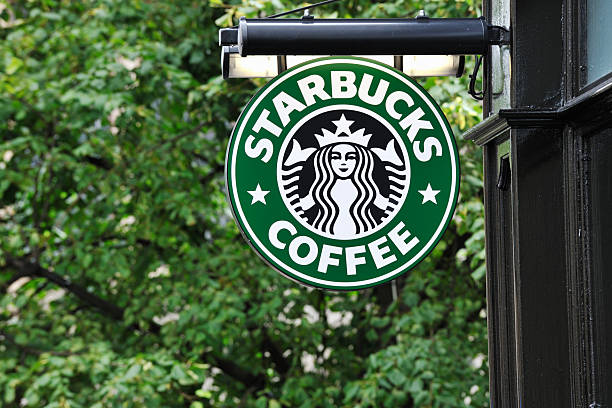

## Section 1: Project Definition
### Project Overview
With the use of Random Forest Model the aim of this project is to predict how much will someone spend based on demographics and offer type

### Problem Statement
Forecasting is crucial for organizing marketing campaigns; therefore, it is worthy to elaborate a prediction model. 

Well-known is the Random Forest model and its forecasting capacity; so using a mimic data set of Starbucks users, this model was implemented and tuned to help Starbucks take some data-driven decisions.

I) How much will someone spend based on demographics and offer type?

### Metrics
Due to the fact of the use of regression models, the basic metrics to apply are Mean Absolute Error, Mean Squared Error, Square Root Mean Squared Error.

In [1]:
## Section 2: Analysis

### Data Exploration
import pandas as pd
import numpy as np
import math
import json

import seaborn as sns
from datetime import datetime, timedelta

import random

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
#portfolio exploration
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
portfolio.channels.value_counts()

[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64

In [5]:
#types of offers
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [6]:
#offer characteristics
portfolio[['difficulty', 'duration', 'reward', 'offer_type']].value_counts()

#The offer types varies in difficulty variation, duration and reward. There are bogo, discount and informational. 


difficulty  duration  reward  offer_type   
0           3         0       informational    1
            4         0       informational    1
5           5         5       bogo             1
            7         5       bogo             1
7           7         3       discount         1
10          5         10      bogo             1
            7         2       discount         1
                      10      bogo             1
            10        2       discount         1
20          10        5       discount         1
dtype: int64

In [7]:
# profile exploration
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
#trasncript exploration
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [9]:
#number of events
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

The case explains that the offers will be counted only if the offer is completed, which has the same time as the transaction. It means that each offer completed has a transaction event at the same time, which becomes a unit of analysis. Therefore, in this study, the offers completed will only be taken into account

In [10]:
# example case
transcript[transcript.person == '94de646f7b6041228ca7dec82adb97d2'][['value', 'time', 'event']].head(10)

,value,time,event
2276,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,offer received
16010,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},6,offer viewed
24531,{'amount': 7.41},30,transaction
24532,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,30,offer completed
42252,{'amount': 1.47},102,transaction
55475,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},168,offer received
75256,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},186,offer viewed
77624,{'amount': 2.62},192,transaction
81725,{'amount': 0.59},204,transaction
93913,{'amount': 2.2800000000000002},246,transaction


For example, this person received and have and completed an offer at time 30 and paid an amount of 7.41 dollars.
The variable 'value' has dictionaries in each observation; it will be cleaned to have the amount and the offer id in the same row

In [11]:
# Cleaning value var
transcript['value_keys'] = transcript.value.apply(lambda x: list(x.items())[0][0])

#extract values
transcript['value_values'] = transcript.value.apply(lambda x: list(x.items())[0][1])

#convert to numeric to extract the values
transcript['amount'] = pd.to_numeric(transcript.value_values, errors='coerce')

## Data Visualization

<AxesSubplot: xlabel='income', ylabel='Count'>

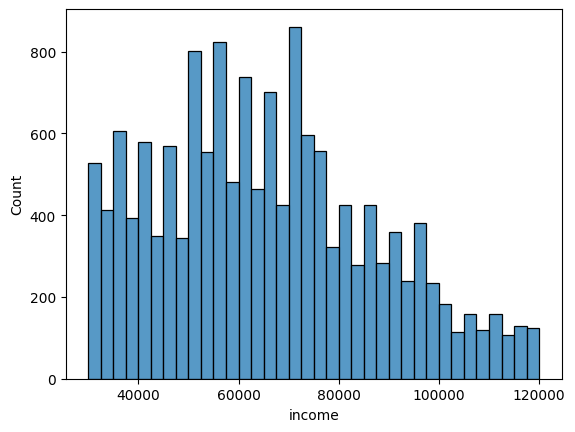

In [12]:
# Income distribution
sns.histplot(profile.income)

<AxesSubplot: xlabel='amount', ylabel='Count'>

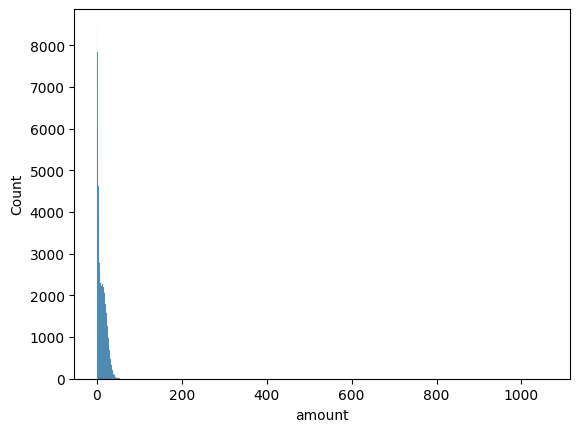

In [13]:
# Amount spent distribution
sns.histplot(transcript.amount)

#The variable amount spent has a lot of outliers. They must be removed in order to have a better prediction

<AxesSubplot: xlabel='gender', ylabel='Count'>

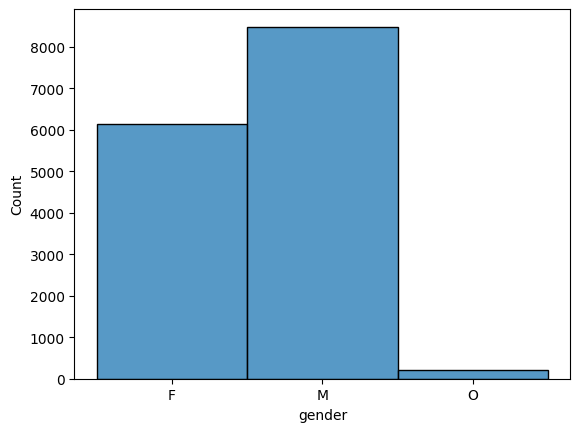

In [14]:
sns.histplot(profile.gender)

## Section 3: Methodology

### Data preprocessing

In [15]:
# Merging data
# separate the amount and offer id an then merge them by person and time
temp1 = transcript[transcript.value_keys == 'amount']
temp2 = transcript[transcript.value_keys == 'offer_id']

temp1.columns
temp1 = temp1[['person', 'time', 'value_values']]
temp1.columns = ['person', 'time', 'amount']

temp2 = temp2[['person', 'time', 'value_values', 'event']]
temp2.columns = ['person', 'time', 'offer_id', 'event']

#merge by person and time
df = temp1.merge(temp2, how = 'inner', on = ['person', 'time'])

#merge df with profile
profile.columns =['gender', 'age', 'person', 'became_member_on', 'income']

df = df.merge(profile, how = 'inner', on = ['person'])

#merge df with portfolio on offer_id
portfolio.columns = ['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'offer_id']
df = df.merge(portfolio, how = 'inner', on = ['offer_id'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 0 to 33578
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   person            33579 non-null  object 
 1   time              33579 non-null  int64  
 2   amount            33579 non-null  object 
 3   offer_id          33579 non-null  object 
 4   event             33579 non-null  object 
 5   gender            32444 non-null  object 
 6   age               33579 non-null  int64  
 7   became_member_on  33579 non-null  int64  
 8   income            32444 non-null  float64
 9   reward            33579 non-null  int64  
 10  channels          33579 non-null  object 
 11  difficulty        33579 non-null  int64  
 12  duration          33579 non-null  int64  
 13  offer_type        33579 non-null  object 
dtypes: float64(1), int64(6), object(7)
memory usage: 3.8+ MB


In [16]:
#Drop the rows where the amount has missing values
df  = df.dropna(subset=['amount'], axis=0)
df.amount = df.amount.astype(float)

In [17]:
#Drop the columns that are identifiers
df = df.drop(['person', 'time', 'offer_id', 'event'], axis= 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 0 to 33578
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   amount            33579 non-null  float64
 1   gender            32444 non-null  object 
 2   age               33579 non-null  int64  
 3   became_member_on  33579 non-null  int64  
 4   income            32444 non-null  float64
 5   reward            33579 non-null  int64  
 6   channels          33579 non-null  object 
 7   difficulty        33579 non-null  int64  
 8   duration          33579 non-null  int64  
 9   offer_type        33579 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 2.8+ MB


In [18]:
#clean channel var
df.channels.value_counts()

for i in df.index:
    if df.channels.loc[i] == ['email', 'mobile', 'social']:
        df.channels.at[i] = [np.nan, 'email', 'mobile', 'social'] 
    
temp = pd.DataFrame(df['channels'].tolist(), index=df.index)

temp[2].value_counts() # test! there must be just mobile option with 30159 obs

mobile    30159
Name: 2, dtype: int64

In [19]:
# Transform channel var to dummies
temp['web'] = np.where(temp[0] == 'web', 1, 0) #transform to dummies variables
temp['email'] = np.where(temp[1] == 'email', 1, 0)
temp['mobile'] = np.where(temp[2] == 'mobile', 1, 0)
temp['social'] = np.where(temp[3] == 'social', 1, 0)

temp.web.value_counts()

1    29891
0     3688
Name: web, dtype: int64

In [20]:
temp.email.value_counts() #email does not have variability, it will be dropped

1    33579
Name: email, dtype: int64

In [21]:
#merge temp with df
temp = temp.drop([0, 1 , 2 , 3, 'email'], axis = 1) 

df = pd.concat([df, temp], axis = 1) 
df.info()
df = df.drop(['channels'], axis = 1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 0 to 33578
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   amount            33579 non-null  float64
 1   gender            32444 non-null  object 
 2   age               33579 non-null  int64  
 3   became_member_on  33579 non-null  int64  
 4   income            32444 non-null  float64
 5   reward            33579 non-null  int64  
 6   channels          33579 non-null  object 
 7   difficulty        33579 non-null  int64  
 8   duration          33579 non-null  int64  
 9   offer_type        33579 non-null  object 
 10  web               33579 non-null  int32  
 11  mobile            33579 non-null  int32  
 12  social            33579 non-null  int32  
dtypes: float64(2), int32(3), int64(5), object(3)
memory usage: 4.2+ MB


In [22]:
#clean became member and then drop
df['timeMember'] = pd.to_datetime(df.became_member_on.astype(str), format='%Y%m%d')
limit_time = df['timeMember'].max()

df['timeMember'] = limit_time - df.timeMember
df['timeMember'] = df.timeMember.dt.days

df = df.drop(['became_member_on'], axis= 1)

df.info()

#Became_member_on variable has been changed to timeMember which correspond to the number of days of being a member since the last user membership

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 0 to 33578
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   amount      33579 non-null  float64
 1   gender      32444 non-null  object 
 2   age         33579 non-null  int64  
 3   income      32444 non-null  float64
 4   reward      33579 non-null  int64  
 5   difficulty  33579 non-null  int64  
 6   duration    33579 non-null  int64  
 7   offer_type  33579 non-null  object 
 8   web         33579 non-null  int32  
 9   mobile      33579 non-null  int32  
 10  social      33579 non-null  int32  
 11  timeMember  33579 non-null  int64  
dtypes: float64(2), int32(3), int64(5), object(2)
memory usage: 4.0+ MB


In [23]:
#Pull a list of the column names of the categorical variables
cat_df = df.select_dtypes(include=['object'])
cat_df.columns
cat_df
cat_cols_lst = cat_df.columns

In [24]:
#Convert variables to dummies
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

df_new = create_dummy_df(df, cat_cols_lst, dummy_na=False) #Use your newly created function

df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 0 to 33578
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   amount               33579 non-null  float64
 1   age                  33579 non-null  int64  
 2   income               32444 non-null  float64
 3   reward               33579 non-null  int64  
 4   difficulty           33579 non-null  int64  
 5   duration             33579 non-null  int64  
 6   web                  33579 non-null  int32  
 7   mobile               33579 non-null  int32  
 8   social               33579 non-null  int32  
 9   timeMember           33579 non-null  int64  
 10  gender_M             33579 non-null  uint8  
 11  gender_O             33579 non-null  uint8  
 12  offer_type_discount  33579 non-null  uint8  
dtypes: float64(2), int32(3), int64(5), uint8(3)
memory usage: 3.5 MB


In [25]:
#Missing values
df_new[df_new.income.isnull()].shape[0]/df_new.shape[0]*100 #3.4% has income null. Is relatively low the case, so the rows null will be deleted

3.380088745942404

In [26]:
#Drop missing values
df_new = df_new.dropna(axis = 0)

In [27]:
#Duplicated
df_new.duplicated().sum()
df_new=df_new[~df_new.duplicated()]

In [28]:
#Save as pickle (Checkpoint)
df_new.to_pickle("df_clean.pkl")

In [29]:
#Read df_clean
df = pd.read_pickle('df_clean.pkl')

In [30]:
#Import some libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32063 entries, 0 to 33578
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   amount               32063 non-null  float64
 1   age                  32063 non-null  int64  
 2   income               32063 non-null  float64
 3   reward               32063 non-null  int64  
 4   difficulty           32063 non-null  int64  
 5   duration             32063 non-null  int64  
 6   web                  32063 non-null  int32  
 7   mobile               32063 non-null  int32  
 8   social               32063 non-null  int32  
 9   timeMember           32063 non-null  int64  
 10  gender_M             32063 non-null  uint8  
 11  gender_O             32063 non-null  uint8  
 12  offer_type_discount  32063 non-null  uint8  
dtypes: float64(2), int32(3), int64(5), uint8(3)
memory usage: 2.4 MB


In [32]:
#identify outliers and remove from dataframe
q1 = np.percentile(df.amount, 25)
q3 = np.percentile(df.amount, 75)
iqr = q3-q1
lower = q1-1.5*iqr
upper = q3+1.5*iqr

"The number of outliers are {diff}".format(diff = df.shape[0] - df[(df.amount<upper)&(df.amount>lower)].shape[0])

'The number of outliers are 552'

In [33]:
"They represent the {percen}% of the total of observations".format(percen = \
                                                                   round(((df.shape[0] - df[(df.amount<upper)&(df.amount>lower)].shape[0])/df.shape[0]*100), 2))

'They represent the 1.72% of the total of observations'

In this case, due to the fact that the amount of outliers are just 1.72% of the total cases, they will be removed

In [34]:
df = df[(df.amount<upper)&(df.amount>lower)]

Text(0.5, 0, 'amount')

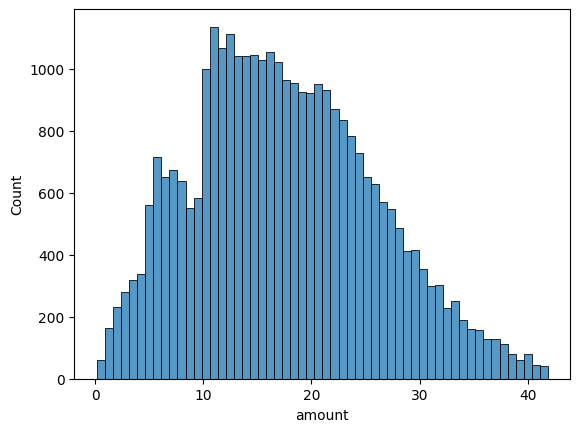

In [35]:
#Distibution of money spent
sns.histplot(df.amount)
plt.xlabel('amount')

### Implementation

In [36]:
def metricsProject(Y, YPred):
    '''
    Function to calculate Absolute error, Mean Squared Error, Root Squared Error
    Input :
        - Y_test
        - Predictions = outcome of prediciting with the X_test set
    Output:
        - The metrics: Absolute error, Mean Squared Error, Root Squared Error
    Input
    '''

    return 'Absolute error: {abError}. \
    Mean Squared Error: {meanSqError}. \
    Root Squared Error: {RootSqError}'.format(abError = metrics.mean_absolute_error(Y, YPred),
                                                meanSqError = metrics.mean_squared_error(Y, YPred),
                                                RootSqError = np.sqrt(metrics.mean_squared_error(Y, YPred)))

In [37]:
df.columns

Index(['amount', 'age', 'income', 'reward', 'difficulty', 'duration', 'web',
       'mobile', 'social', 'timeMember', 'gender_M', 'gender_O',
       'offer_type_discount'],
      dtype='object')

In [38]:
# Split the data 
Y = np.array(df['amount'])
X = np.array(df[['age', 'income', 'reward', 'difficulty', 'duration', 'web',
       'mobile', 'social', 'timeMember', 'gender_M', 'gender_O',
       'offer_type_discount']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)

In [39]:
from sklearn.ensemble import RandomForestRegressor

#Create an instance of RandomForestRegressor() called rfr and fit it to the training data
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [40]:
predictions_rfr = rfr.predict(X_test)
Y_hat_rfr = rfr.predict(X_train)

Text(0, 0.5, 'RandomForest_predictions')

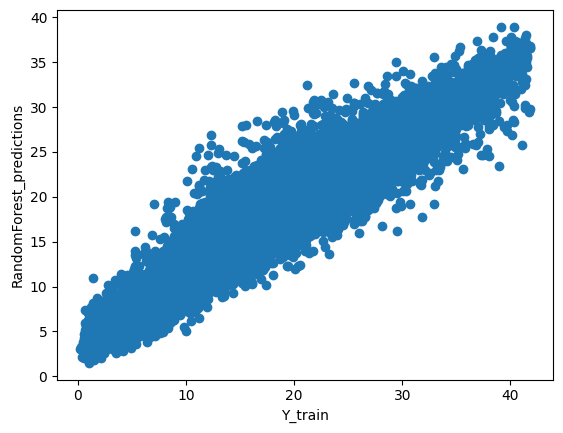

In [41]:
plt.scatter(Y_train, Y_hat_rfr)
plt.xlabel('Y_train')
plt.ylabel('RandomForest_predictions')

In [42]:
metricsProject(Y_train, Y_hat_rfr)

'Absolute error: 1.9949769352407878.     Mean Squared Error: 7.0566277910087285.     Root Squared Error: 2.656431401525123'

In [43]:
metricsProject(Y_test, predictions_rfr)

'Absolute error: 4.822466808551378.     Mean Squared Error: 37.74134301042743.     Root Squared Error: 6.1433983275079465'

Comparing the metrics using the Y_train and Y_test data sets shows that the model is overfitting. It predicted well in the train data, while in the test data, the errors increased notably. Therefore, the hyperparameters will be tuned to get the best scenario.

Text(0, 0.5, 'RandomForest_predictions')

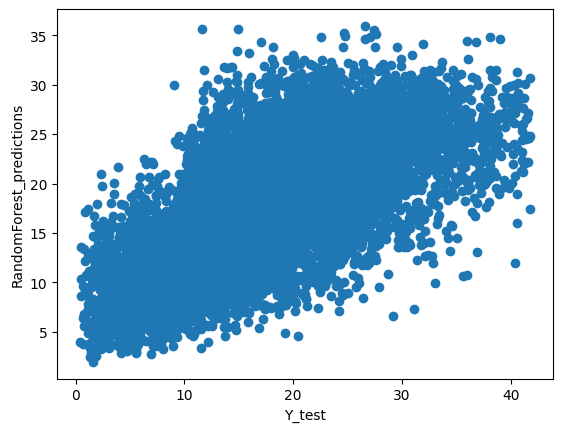

In [44]:
plt.scatter(Y_test, predictions_rfr)
plt.xlabel('Y_test')
plt.ylabel('RandomForest_predictions')

### Refinement

In [48]:
#Getting the parameters of the random forest regressor
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [49]:
#Getting the lists of parameters to test with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
min_samples_leaf = [2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 1100, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 60, 110, None], 'min_samples_leaf': [2, 4], 'bootstrap': [True, False]}


In [50]:
rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)


In [51]:
# Fit the random search model
rfr_random.fit(X_train, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\R RSTUDIO\Documents\GitHub\ForecastingAmountSpent\.venv\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 60, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4],
                                        'n_estimators': [200, 1100, 2000]},
                   random_state=42, verbose=2)

In [52]:
rfr_random.best_estimator_

RandomForestRegressor(max_depth=10, max_features='auto', min_samples_leaf=4,
                      n_estimators=1100, random_state=42)

In [54]:
#save the model (checkpoint)
import pickle
filename = 'finalized_model.sav'
pickle.dump(rfr_random, open(filename, 'wb'))

In [55]:
#load the model
rfr_random = pickle.load(open('finalized_model.sav', 'rb'))

In [56]:
#Getting the predictions with X_test and X_train
predictions_rfr_random = rfr_random.predict(X_test)
Y_hat_rfr_random = rfr_random.predict(X_train)


Text(0, 0.5, 'RandomForest_tunned_predictions')

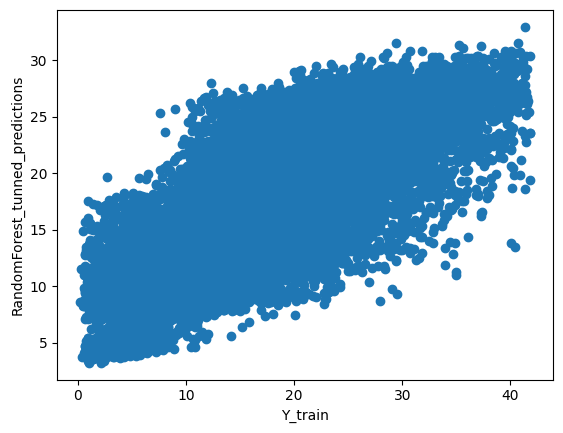

In [ ]:
#Graph of results of predictions with train data set
plt.scatter(Y_train, Y_hat_rfr_random)
plt.xlabel('Y_train')
plt.ylabel('RandomForest_tunned_predictions')

Text(0, 0.5, 'RandomForest_tunned_predictions')

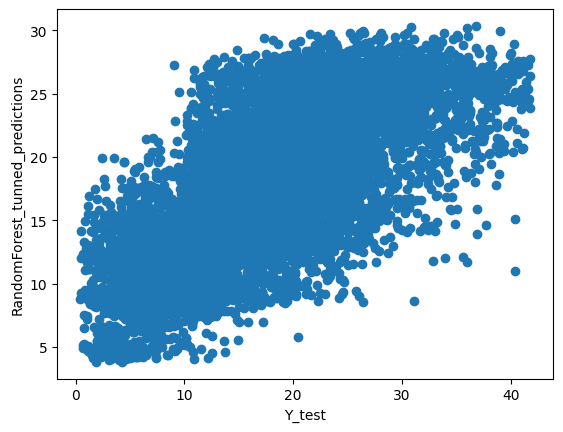

In [57]:
#Graph of results of predictions with test data set
plt.scatter(Y_test, predictions_rfr_random)
plt.xlabel('Y_test')
plt.ylabel('RandomForest_tunned_predictions')

In [ ]:
#predictions with training data set
metricsProject(Y_train, Y_hat_rfr_random)

'Absolute error: 4.278716939572983.     Mean Squared Error: 29.617573739093384.     Root Squared Error: 5.442203022590519'

In [ ]:
#predictions with test data set
metricsProject(Y_test, predictions_rfr_random)

'Absolute error: 4.638484186328544.     Mean Squared Error: 34.62327309525098.     Root Squared Error: 5.884154407835588'

Now, the model is no longer overfitting and the error of the test data set diminished

In [58]:
#percentage of the error with respect to the mean
(5.88)/df.amount.mean()*100

33.54031998373133

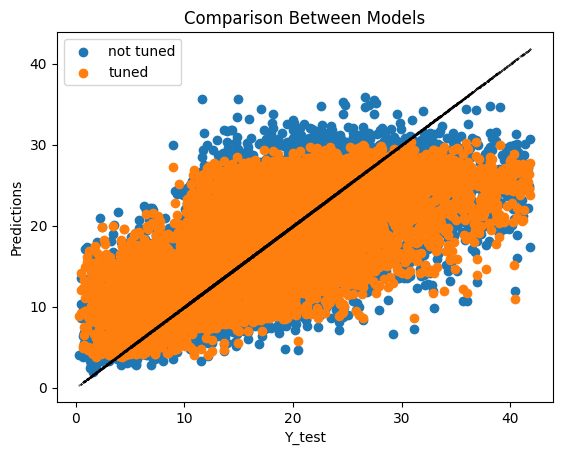

In [86]:
#Comparison charts
plt.scatter(Y_test, predictions_rfr, label = 'not tuned', zorder = 1)
plt.scatter(Y_test, predictions_rfr_random, label = 'tuned', zorder = 2)
plt.scatter(Y_test, Y_test, color = 'black', s = 0.1, zorder = 3)
plt.xlabel('Y_test')
plt.ylabel('Predictions')
plt.title('Comparison Between Models')
plt.legend()